In [7]:
# Import all required libraries
import h5py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, welch
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import os

print("All libraries imported successfully!")
print(f"TensorFlow version: {tf.__version__}")

ImportError: dlopen(/Users/ashmith/ml/env/lib/python3.8/site-packages/tensorflow/python/_pywrap_dtensor_device.so, 0x0002): symbol not found in flat namespace '__ZN10tensorflow7dtensor4Mesh10CreateMeshERKNSt3__112basic_stringIcNS2_11char_traitsIcEENS2_9allocatorIcEEEERKNS2_6vectorIS8_NS6_IS8_EEEERKNSB_IxNS6_IxEEEESJ_SF_SJ_SF_b'

In [ ]:
# Load the MATLAB v7.3 file using h5py
mat_file = h5py.File('data/data_s1_64.mat', 'r')

# Extract the main data array
data_key = list(mat_file.keys())[0]
eeg_data = np.array(mat_file[data_key])

print(f"Data key: {data_key}")
print(f"Data shape: {eeg_data.shape}")
print(f"\nActual structure (from paper):")
print(f"  Dimension 0 (12): Conditions")
print(f"  Dimension 1 (60): Frequencies (1-60 Hz)")
print(f"  Dimension 2 (5140): Timepoints (5.14s at 1000 Hz)")
print(f"  Dimension 3 (64): Channels")
print(f"  Dimension 4 (2): Modulation Depths (0=Low, 1=High)")

Data key: datas
Data shape: (12, 60, 5140, 64, 2)

Actual structure (from paper):
  Dimension 0 (12): Conditions
  Dimension 1 (60): Frequencies (1-60 Hz)
  Dimension 2 (5140): Timepoints (5.14s at 1000 Hz)
  Dimension 3 (64): Channels
  Dimension 4 (2): Modulation Depths (0=Low, 1=High)


In [ ]:
# Load channel information with correct encoding
channel_info = pd.read_csv('data/Electrode_channels.csv', encoding='utf-8')
print("Channel information loaded!")
print(f"\nFirst 10 channels:")
print(channel_info[['labels', 'index']])

Channel information loaded!

First 10 channels:
   labels  index
0   'FP1'      1
1   'FPz'      2
2   'FP2'      3
3   'AF3'      4
4   'AF4'      5
..    ...    ...
59  'CB1'     60
60   'O1'     61
61   'Oz'     62
62   'O2'     63
63  'CB2'     64

[64 rows x 2 columns]


In [ ]:
# Find correct channel indices for O1, O2, P3, P4
target_channels = ['O1', 'O2', 'P3', 'P4','PO3','PO4']
channel_indices = []

for ch_name in target_channels:
    # Remove quotes from labels column
    idx = channel_info[channel_info['labels'].str.strip("'") == ch_name].index
    if len(idx) > 0:
        channel_indices.append(idx[0])
        print(f"{ch_name}: index {idx[0]}")
    else:
        print(f"Warning: {ch_name} not found")

print(f"\nChannel indices for {target_channels}: {channel_indices}")

O1: index 60
O2: index 62
P3: index 45
P4: index 49
PO3: index 54
PO4: index 56

Channel indices for ['O1', 'O2', 'P3', 'P4', 'PO3', 'PO4']: [60, 62, 45, 49, 54, 56]


In [ ]:
#Defining indicies for easy access
freq_8hz_idx = 7
freq_14hz_idx = 13

high_depth_idx = 1

In [ ]:
#Isolate high depth data
data_high_depth = eeg_data[:, :, :, :, high_depth_idx]

In [ ]:
#Separate frequencies from isolated high depth data
raw_8hz = data_high_depth[:, freq_8hz_idx, :, :]
raw_14hz = data_high_depth[:, freq_14hz_idx, :, :]

In [ ]:
#Extract only the desired channels
final_8hz = raw_8hz[:, :, channel_indices]
final_14hz = raw_14hz[:, :, channel_indices]

In [ ]:
import numpy as np
import h5py
import os
import glob
from scipy.signal import welch

# --- CONFIGURATION ---
DATA_FOLDER = 'data' # Keep your absolute path
TARGET_FREQS = {8: 7, 14: 13}

# CHANGED: Use High Beta frequencies (Far from 8/14Hz) for "Neither"
# 20Hz (Idx 19), 26Hz (Idx 25), 30Hz (Idx 29)
NEITHER_FREQ_INDICES = [19, 25, 29]

MY_CHANNELS = [60, 62, 45, 49, 54, 56] 
HIGH_DEPTH_IDX = 1

FS = 125
WINDOW_SIZE = 1 * FS
STEP_SIZE = int(0.5 * FS) # Increased step to 0.5s to reduce data redundancy

def process_single_subject(file_path):
    try:
        with h5py.File(file_path, 'r') as mat_file:
            data_keys = [k for k in mat_file.keys() if not k.startswith('#')]
            if not data_keys: return [], []
            data_key = data_keys[0]
            eeg_data = np.array(mat_file[data_key])
            
    except Exception as e:
        print(f"Error: {e}")
        return [], []

    X_sub = []
    y_sub = []

    # --- PART 1: TARGETS (0 & 1) ---
    for hz_label, freq_idx in TARGET_FREQS.items():
        subset_raw = eeg_data[:, freq_idx, :, MY_CHANNELS, HIGH_DEPTH_IDX]
        if subset_raw.shape == (len(MY_CHANNELS), 12, 5140):
            subset_raw = subset_raw.transpose(1, 2, 0)
        
        subset_125hz = subset_raw[:, ::8, :] # Downsample

        for trial_idx in range(subset_125hz.shape[0]):
            trial_data = subset_125hz[trial_idx]
            for start in range(0, trial_data.shape[0] - WINDOW_SIZE, STEP_SIZE):
                window = trial_data[start:start+WINDOW_SIZE, :]
                
                # PSD Calculation
                f, psd = welch(window, fs=FS, nperseg=WINDOW_SIZE, axis=0)
                mask = (f >= 3) & (f <= 30)
                psd_focused = psd[mask, :]
                
                # Average Channels
                psd_mean = np.mean(psd_focused, axis=1)
                
                # --- CRITICAL FIX: NORMALIZATION ---
                # Convert to Relative Power (0.0 to 1.0)
                # This makes "Quiet" brains look like "Loud" brains
                total_power = np.sum(psd_mean)
                if total_power > 0:
                    psd_norm = psd_mean / total_power
                else:
                    psd_norm = psd_mean
                
                X_sub.append(psd_norm)
                y_sub.append(0 if hz_label == 8 else 1)

    # --- PART 2: NEITHER (2) ---
    for freq_idx in NEITHER_FREQ_INDICES:
        subset_raw = eeg_data[:, freq_idx, :, MY_CHANNELS, HIGH_DEPTH_IDX]
        if subset_raw.shape == (len(MY_CHANNELS), 12, 5140):
            subset_raw = subset_raw.transpose(1, 2, 0)
        subset_125hz = subset_raw[:, ::8, :]

        for trial_idx in range(subset_125hz.shape[0]):
            trial_data = subset_125hz[trial_idx]
            for start in range(0, trial_data.shape[0] - WINDOW_SIZE, STEP_SIZE):
                window = trial_data[start:start+WINDOW_SIZE, :]
                
                f, psd = welch(window, fs=FS, nperseg=WINDOW_SIZE, axis=0)
                mask = (f >= 3) & (f <= 30)
                psd_focused = psd[mask, :]
                psd_mean = np.mean(psd_focused, axis=1)
                
                # Normalize "Neither" class too
                total_power = np.sum(psd_mean)
                if total_power > 0:
                    psd_norm = psd_mean / total_power
                else:
                    psd_norm = psd_mean
                
                X_sub.append(psd_norm)
                y_sub.append(2)

    return X_sub, y_sub

# --- MAIN EXECUTION ---
all_X = []
all_y = []

mat_files = glob.glob(os.path.join(DATA_FOLDER, "*.mat"))
print(f"Found {len(mat_files)} files.")

for f in mat_files:
    X_temp, y_temp = process_single_subject(f)
    if len(X_temp) > 0:
        all_X.extend(X_temp)
        all_y.extend(y_temp)
        print(f"Processed {os.path.basename(f)} -> {len(y_temp)} samples")

final_X = np.array(all_X)
final_y = np.array(all_y)

# --- BALANCE CHECK ---
# If Class 2 is much larger, we randomly drop samples to match Class 0
count0 = np.sum(final_y == 0)
count2 = np.sum(final_y == 2)
if count2 > count0 * 1.5:
    print(f"\nBalancing Class 2 (Dropping {count2 - count0} samples)...")
    
    # Get indices of all classes
    idx0 = np.where(final_y == 0)[0]
    idx1 = np.where(final_y == 1)[0]
    idx2 = np.where(final_y == 2)[0]
    
    # Randomly pick subset of Class 2 matches size of Class 0
    idx2_downsampled = np.random.choice(idx2, size=len(idx0), replace=False)
    
    # Combine
    final_indices = np.concatenate([idx0, idx1, idx2_downsampled])
    np.random.shuffle(final_indices)
    
    final_X = final_X[final_indices]
    final_y = final_y[final_indices]

print("\n--- DONE ---")
print(f"Final Shape: {final_X.shape}")
print(f"Class Dist: 0={np.sum(final_y==0)}, 1={np.sum(final_y==1)}, 2={np.sum(final_y==2)}")

# Update your workspace variables so you can train immediately
X = final_X
y = final_y

Found 2 subject files.
Loading: data_s2_64.mat...
 -> Added 1020 samples.
Loading: data_s1_64.mat...
 -> Added 1020 samples.

--- GLOBAL PROCESSING COMPLETE ---
Total Samples: (2040, 28)
Class Distribution: 0=408, 1=408, 2=1224
Saved to .npy files!


Original Shape: (2040, 28)
PCA Shape:      (2040, 2)
Explained Variance: [0.20830561 0.12218072]


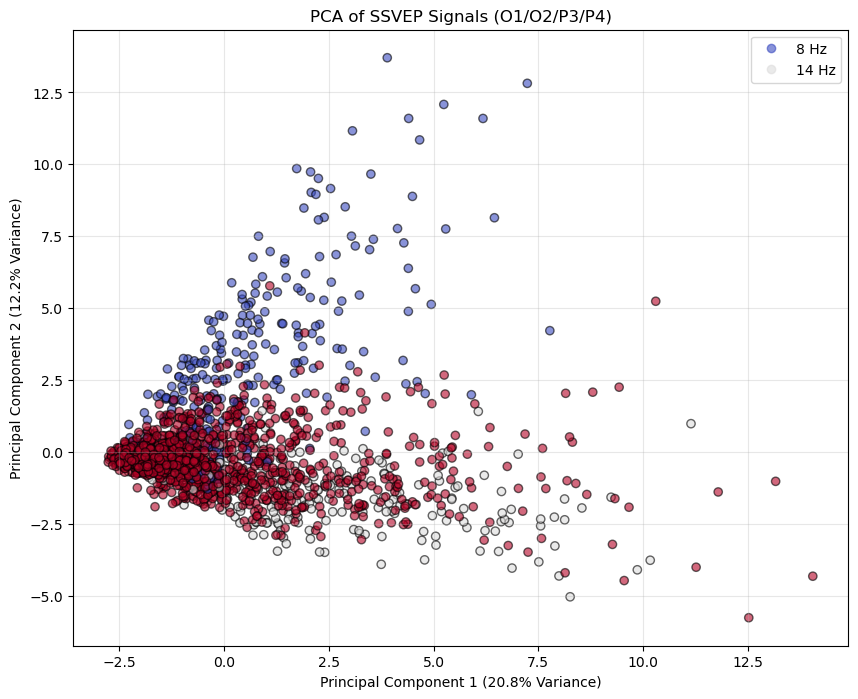

In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# 1. Standardize the Data
# PCA works best when data is centered (Mean=0, Variance=1)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 2. Apply PCA (Reduce 28 dimensions -> 2 dimensions)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

print(f"Original Shape: {X.shape}")
print(f"PCA Shape:      {X_pca.shape}")
print(f"Explained Variance: {pca.explained_variance_ratio_}") 
# This tells us how much information was preserved (e.g., [0.45, 0.22] means 67% of signal kept)

# 3. Plot the Results
plt.figure(figsize=(10, 8))

# Scatter plot: X_pca[:, 0] is the x-axis, X_pca[:, 1] is the y-axis
# c=y colors the dots based on label (0=8Hz, 1=14Hz)
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='coolwarm', alpha=0.6, edgecolors='k')

# Add legend and labels
classes = ['8 Hz', '14 Hz']
plt.legend(handles=scatter.legend_elements()[0], labels=classes)
plt.title('PCA of SSVEP Signals (O1/O2/P3/P4)')
plt.xlabel(f'Principal Component 1 ({pca.explained_variance_ratio_[0]:.1%} Variance)')
plt.ylabel(f'Principal Component 2 ({pca.explained_variance_ratio_[1]:.1%} Variance)')
plt.grid(True, alpha=0.3)

plt.show()

Training Shape: (1632, 28, 1)
Testing Shape:  (408, 28, 1)

--- STARTING TRAINING ---
Epoch 1/40


2025-12-04 01:51:36.405098: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


102/102 [==============================] - 1s 5ms/step - loss: 1.1207 - accuracy: 0.6373 - val_loss: 0.5898 - val_accuracy: 0.7721
Epoch 2/40
 15/102 [===>..........................] - ETA: 0s - loss: 0.6396 - accuracy: 0.7250

2025-12-04 01:51:36.946003: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


102/102 [==============================] - 0s 4ms/step - loss: 0.6373 - accuracy: 0.7610 - val_loss: 0.5579 - val_accuracy: 0.7770
Epoch 3/40
102/102 [==============================] - 0s 5ms/step - loss: 0.5710 - accuracy: 0.7849 - val_loss: 0.5721 - val_accuracy: 0.7770
Epoch 4/40
102/102 [==============================] - 0s 5ms/step - loss: 0.4671 - accuracy: 0.8168 - val_loss: 0.5206 - val_accuracy: 0.7843
Epoch 5/40
102/102 [==============================] - 0s 5ms/step - loss: 0.4668 - accuracy: 0.8180 - val_loss: 0.5368 - val_accuracy: 0.7892
Epoch 6/40
102/102 [==============================] - 0s 4ms/step - loss: 0.4662 - accuracy: 0.8211 - val_loss: 0.4967 - val_accuracy: 0.7917
Epoch 7/40
102/102 [==============================] - 0s 4ms/step - loss: 0.4567 - accuracy: 0.8266 - val_loss: 0.4873 - val_accuracy: 0.7917
Epoch 8/40
102/102 [==============================] - 0s 4ms/step - loss: 0.4602 - accuracy: 0.8217 - val_loss: 0.4867 - val_accuracy: 0.7941
Epoch 9/40
102/10

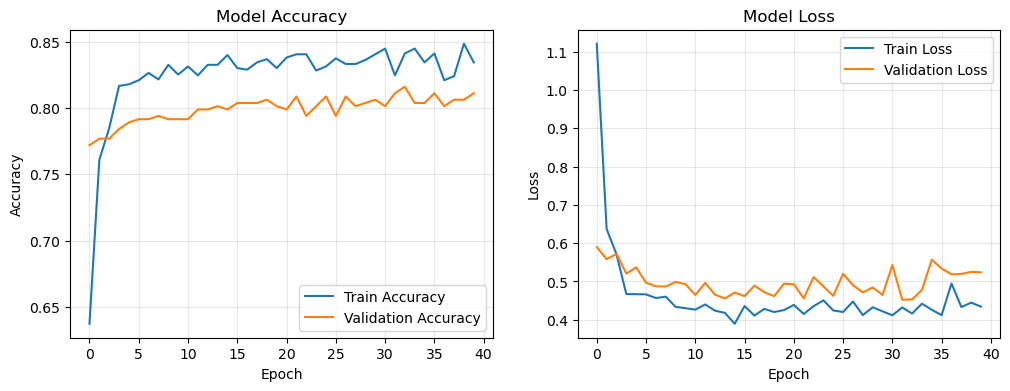


Model saved as 'neuroquest_model_s1.h5'


/Users/ashmith/ml/env/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# 1. PREPARE DATA
# Reshape X to add the "channel" dimension for the CNN
# Current shape: (408, 28) -> New shape: (408, 28, 1)
X_cnn = X[..., np.newaxis]

# Split into Training (80%) and Testing (20%)
# Stratify=y ensures we get an equal mix of 8Hz and 14Hz in both sets
X_train, X_test, y_train, y_test = train_test_split(X_cnn, y, test_size=0.2, stratify=y, random_state=42)

print(f"Training Shape: {X_train.shape}")
print(f"Testing Shape:  {X_test.shape}")

# 2. BUILD THE BRAIN (1D CNN)
model = tf.keras.Sequential([
    # Layer 1: Convolution
    tf.keras.layers.Conv1D(filters=16, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    
    # --- NEW: Dropout Layer ---
    # Randomly drops 20% of connections to prevent memorization
    tf.keras.layers.Dropout(0.2),

    # Layer 2: Flatten
    tf.keras.layers.Flatten(),
    
    # Layer 3: Dense
    tf.keras.layers.Dense(32, activation='relu'),
    
    # --- NEW: Dropout Layer ---
    # A stronger dropout before the final decision
    tf.keras.layers.Dropout(0.4),
    
    # Layer 4: Output
    tf.keras.layers.Dense(3, activation='softmax')
])

# Compile with a slightly lower learning rate for stability
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


# 3. TRAIN
print("\n--- STARTING TRAINING ---")
history = model.fit(X_train, y_train, 
                    epochs=40, 
                    batch_size=16, 
                    validation_data=(X_test, y_test),
                    verbose=1)

# 4. VISUALIZE LEARNING
plt.figure(figsize=(12, 4))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.show()

# 5. SAVE THE MODEL
model.save('neuroquest_model_s1.h5')
print("\nModel saved as 'neuroquest_model_s1.h5'")

In [ ]:
import keras_tuner as kt
import tensorflow as tf
from sklearn.model_selection import train_test_split
import numpy as np

X_cnn = X[..., np.newaxis]
X_train, X_test, y_train, y_test = train_test_split(X_cnn, y, test_size=0.2, stratify=y, random_state=42)

# --- 2. DEFINE THE MODEL-BUILDING FUNCTION ---
def build_model(hp):
    model = tf.keras.Sequential()
    
    # Tunable Parameter 1: Number of filters in the Conv Layer
    hp_filters = hp.Int('filters', min_value=8, max_value=64, step=8)
    
    # Tunable Parameter 2: Kernel size (Window of the scan)
    hp_kernel = hp.Choice('kernel_size', values=[3, 5, 7])
    
    model.add(tf.keras.layers.Conv1D(
        filters=hp_filters, 
        kernel_size=hp_kernel, 
        activation='relu', 
        input_shape=(X_train.shape[1], 1)
    ))
    
    model.add(tf.keras.layers.MaxPooling1D(pool_size=2))
    
    # Tunable Parameter 3: Dropout Rate
    hp_dropout = hp.Float('dropout', min_value=0.1, max_value=0.5, step=0.1)
    model.add(tf.keras.layers.Dropout(hp_dropout))
    
    model.add(tf.keras.layers.Flatten())
    
    # Tunable Parameter 4: Dense Layer Size
    hp_units = hp.Int('units', min_value=16, max_value=64, step=16)
    model.add(tf.keras.layers.Dense(units=hp_units, activation='relu'))
    
    model.add(tf.keras.layers.Dropout(hp_dropout))
    
    # Fixed: Output layer now has 3 units for 3 classes (0, 1, 2)
    model.add(tf.keras.layers.Dense(3, activation='softmax'))
    
    # Tunable Parameter 5: Learning Rate
    hp_lr = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp_lr),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

# --- 3. SETUP THE TUNER ---
tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=30,
    factor=3,
    directory='neuroquest_tuning',
    project_name='ssvep_optimization'
)

# Stop early if val_accuracy doesn't improve
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

# --- 4. RUN THE SEARCH ---
print("\n--- STARTING HYPERPARAMETER TUNING ---")
tuner.search(X_train, y_train, epochs=30, validation_data=(X_test, y_test), callbacks=[stop_early])

# --- 5. GET THE BEST MODEL ---
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. 
Best Filters: {best_hps.get('filters')}
Best Kernel: {best_hps.get('kernel_size')}
Best Dropout: {best_hps.get('dropout')}
Best Units: {best_hps.get('units')}
Best LR: {best_hps.get('learning_rate')}
""")

NotFoundError: dlopen(/Users/ashmith/ml/env/lib/python3.8/site-packages/tensorflow-plugins/libmetal_plugin.dylib, 0x0006): symbol not found in flat namespace '_TF_GetInputPropertiesList'

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 22, 40)            320       
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, 11, 40)            0         
 g1D)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 11, 40)            0         
                                                                 
 flatten_2 (Flatten)         (None, 440)               0         
                                                                 
 dense_4 (Dense)             (None, 48)                21168     
                                                                 
 dropout_5 (Dropout)         (None, 48)                0         
                                                      

2025-12-04 01:56:22.690590: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


 94/102 [==========================>...] - ETA: 0s - loss: 0.3931 - accuracy: 0.2606

2025-12-04 01:56:23.569863: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


102/102 [==============================] - 1s 6ms/step - loss: 0.4067 - accuracy: 0.2604 - val_loss: 0.4748 - val_accuracy: 0.2279
Epoch 2/50
102/102 [==============================] - 0s 4ms/step - loss: 4.5560 - accuracy: 0.2384 - val_loss: 3.6097 - val_accuracy: 0.2010
Epoch 3/50
102/102 [==============================] - 0s 4ms/step - loss: 22.0905 - accuracy: 0.2292 - val_loss: 10.6983 - val_accuracy: 0.2010
Epoch 4/50
102/102 [==============================] - 0s 4ms/step - loss: 66.5710 - accuracy: 0.2120 - val_loss: 21.3447 - val_accuracy: 0.2010
Epoch 5/50
102/102 [==============================] - 0s 4ms/step - loss: 96.9104 - accuracy: 0.2304 - val_loss: 50.0003 - val_accuracy: 0.2010
Epoch 6/50
102/102 [==============================] - 0s 4ms/step - loss: 152.0129 - accuracy: 0.2267 - val_loss: 72.7651 - val_accuracy: 0.2010
Epoch 7/50
102/102 [==============================] - 0s 4ms/step - loss: 173.6451 - accuracy: 0.2286 - val_loss: 168.4364 - val_accuracy: 0.2010
Epoc

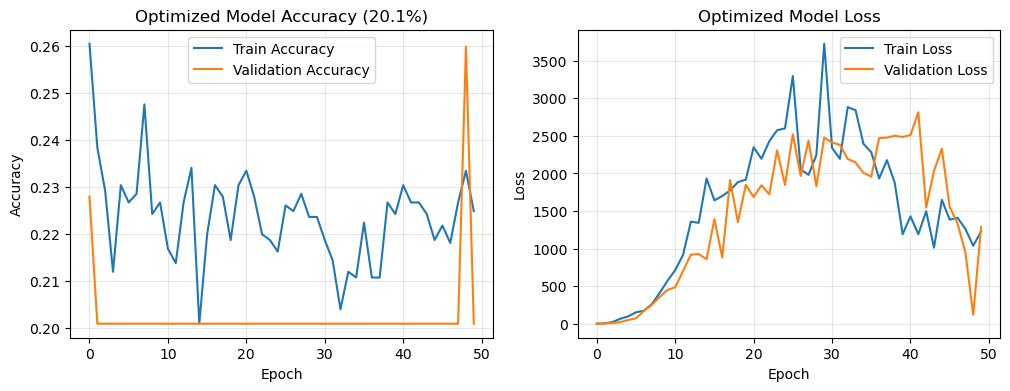

Champion model saved!


/Users/ashmith/ml/env/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

# 1. PREPARE DATA (Same as before)
# Ensure X and y are loaded
X_cnn = X[..., np.newaxis]
X_train, X_test, y_train, y_test = train_test_split(X_cnn, y, test_size=0.2, stratify=y, random_state=42)

# 2. BUILD THE OPTIMIZED MODEL
model = tf.keras.Sequential([
    # Tuned: 40 Filters, Kernel Size 7
    tf.keras.layers.Conv1D(filters=40, kernel_size=7, activation='relu', input_shape=(X_train.shape[1], 1)),
    
    tf.keras.layers.MaxPooling1D(pool_size=2),
    
    # Tuned: Dropout 0.2
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Flatten(),
    
    # Tuned: 48 Units
    tf.keras.layers.Dense(48, activation='relu'),
    
    # Tuned: Dropout 0.2
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Dense(2, activation='softmax')
])

# Tuned: Learning Rate 0.001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

# 3. TRAIN THE CHAMPION
print("\n--- TRAINING OPTIMIZED MODEL ---")
history = model.fit(X_train, y_train, 
                    epochs=50,  # Increased epochs for final convergence
                    batch_size=16, 
                    validation_data=(X_test, y_test),
                    verbose=1)

# 4. EVALUATE
val_loss, val_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"\nFinal Validation Accuracy: {val_acc*100:.2f}%")

# 5. PLOT RESULTS
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title(f'Optimized Model Accuracy ({val_acc*100:.1f}%)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Optimized Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# 6. SAVE
model.save('neuroquest_champion_s1.h5')
print("Champion model saved!")